# Alana Viana
# Tarefa Análise de Votos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
from scipy import stats

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("data/eleicoes_2006_TREINO_CONFIGURADO_LIBRE.csv", index_col="nome")
del train['sequencial_candidato']
del train['cargo']
del train['ano']
test = pd.read_csv("data/eleicoes_2010_TESTE_CONFIGURADO_LIBRE.csv", index_col="nome")

del test['sequencial_candidato']
del test['cargo']
del test['ano']
all_data = pd.concat((train.loc[:,'quantidade_doacoes':'votos'], test.loc[:,'quantidade_doacoes':'votos']))

## Analisar as distribuições das variáveis 

(tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso).

In [3]:
train["votos"] = np.log1p(train["votos"])

In [4]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [5]:
all_data = pd.get_dummies(all_data) # dummies
all_data = all_data.fillna(all_data.mean()) # valores ausentes

##  Variáveis e métodos auxiliares

In [6]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.votos
y_test = test.votos

In [7]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

## Ridge Model

In [8]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)
rmse = -cross_val_score(model_ridge, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.8396952789264265

In [9]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] # The higher the regularization the less prone our model will be to overfit
cv_ridge = [rmse_cv (Ridge (alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("rmse Ridge: {}".format(cv_ridge.min()))

rmse Ridge: 0.908512641693385


In [10]:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)

In [11]:
print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " + str(sum(coef_ridge == 0)) + " variables") 

Ridge picked 172 variables and eliminated the other 30 variables


In [12]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

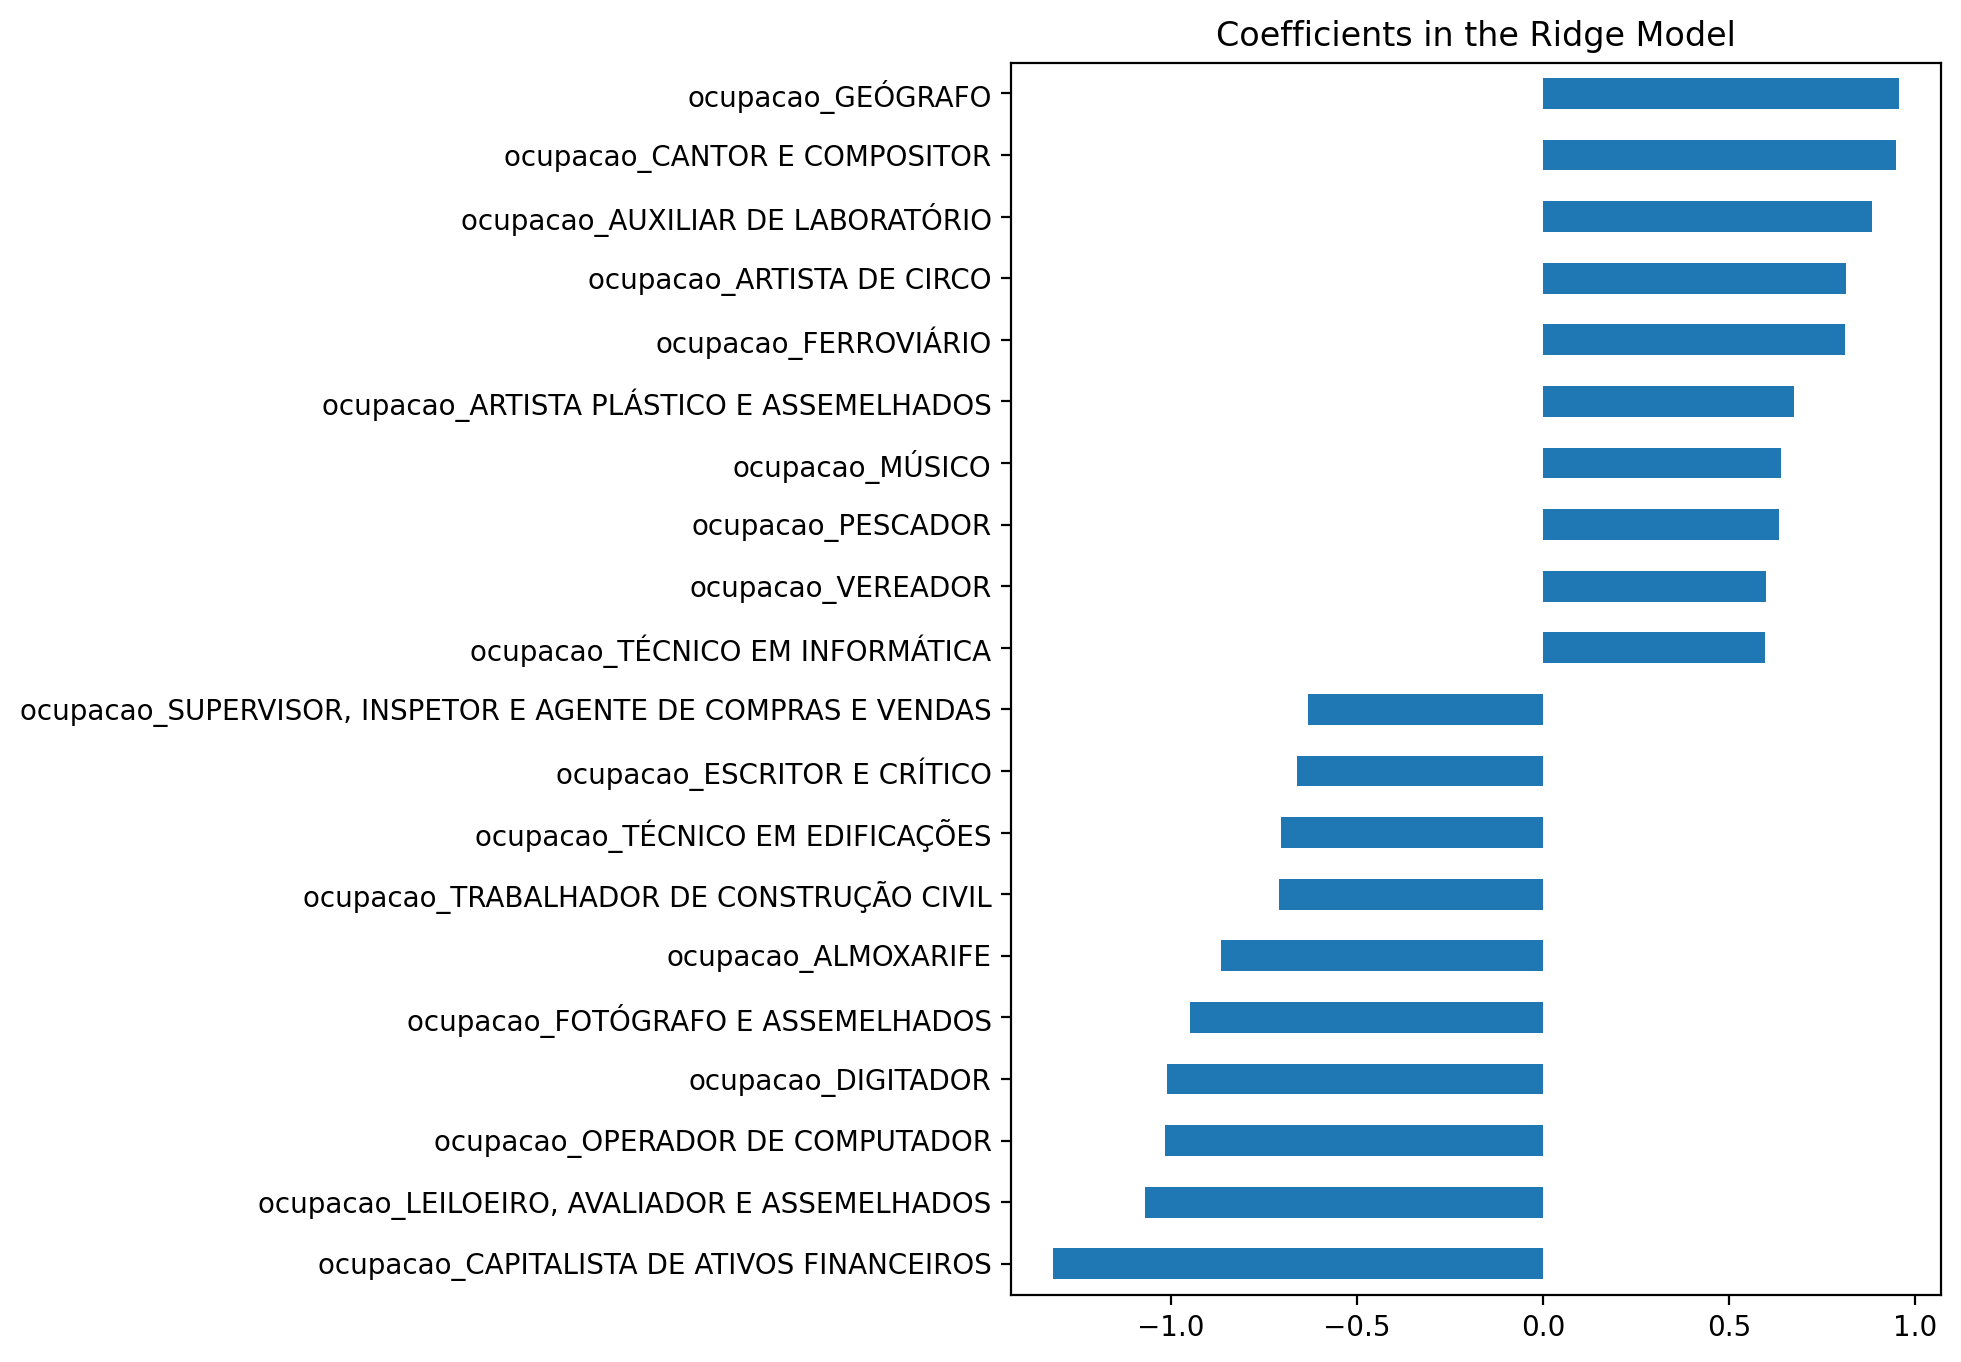

In [13]:
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

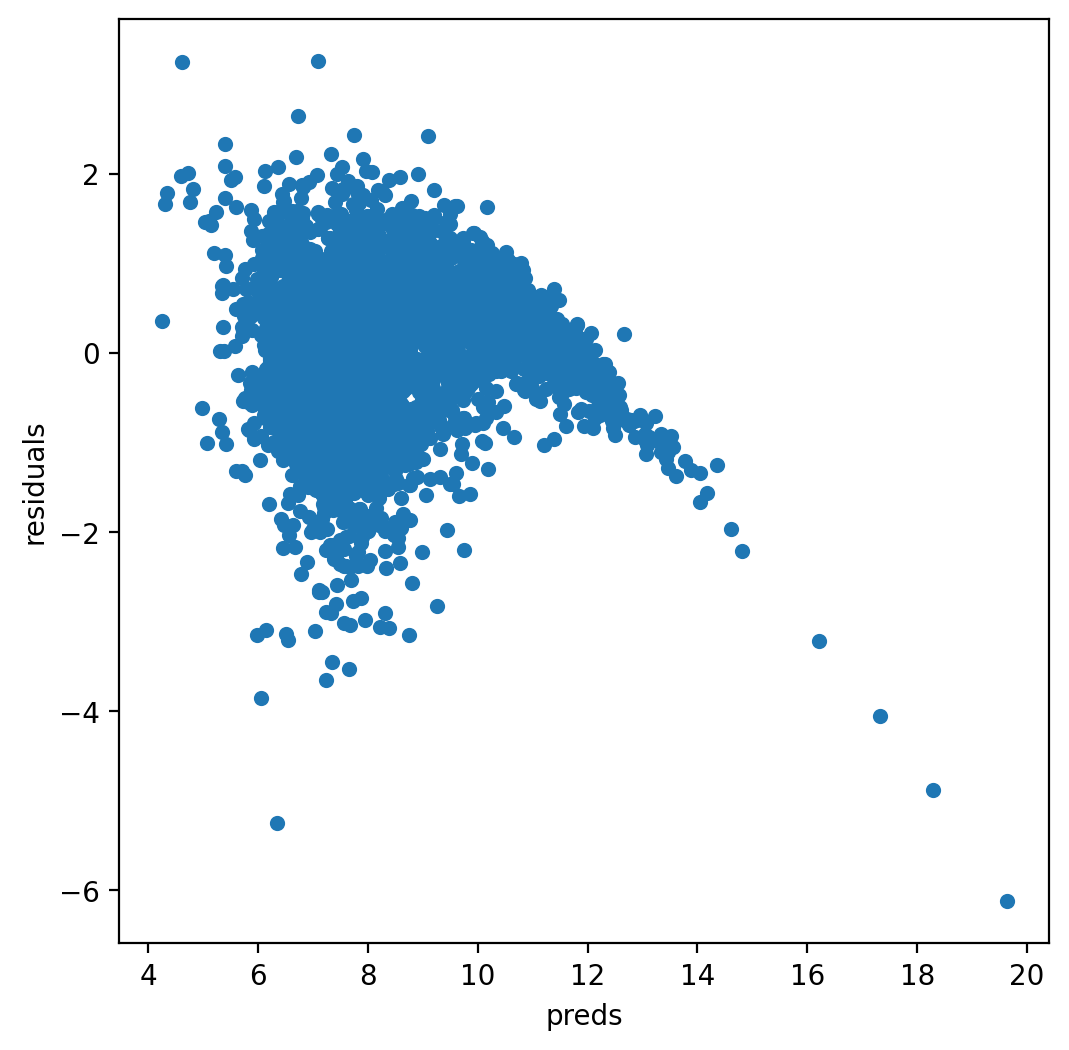

In [14]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## Lassso Model

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=60000000).fit(X_train, y_train)

In [16]:
print("rmse Lasso: {}".format(rmse_cv(model_lasso).mean()))

rmse Lasso: 0.9101543257964085


In [17]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

In [18]:
print("Ridge picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " + str(sum(coef_lasso == 0)) + " variables")

Ridge picked 57 variables and eliminated the other 145 variables


In [19]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

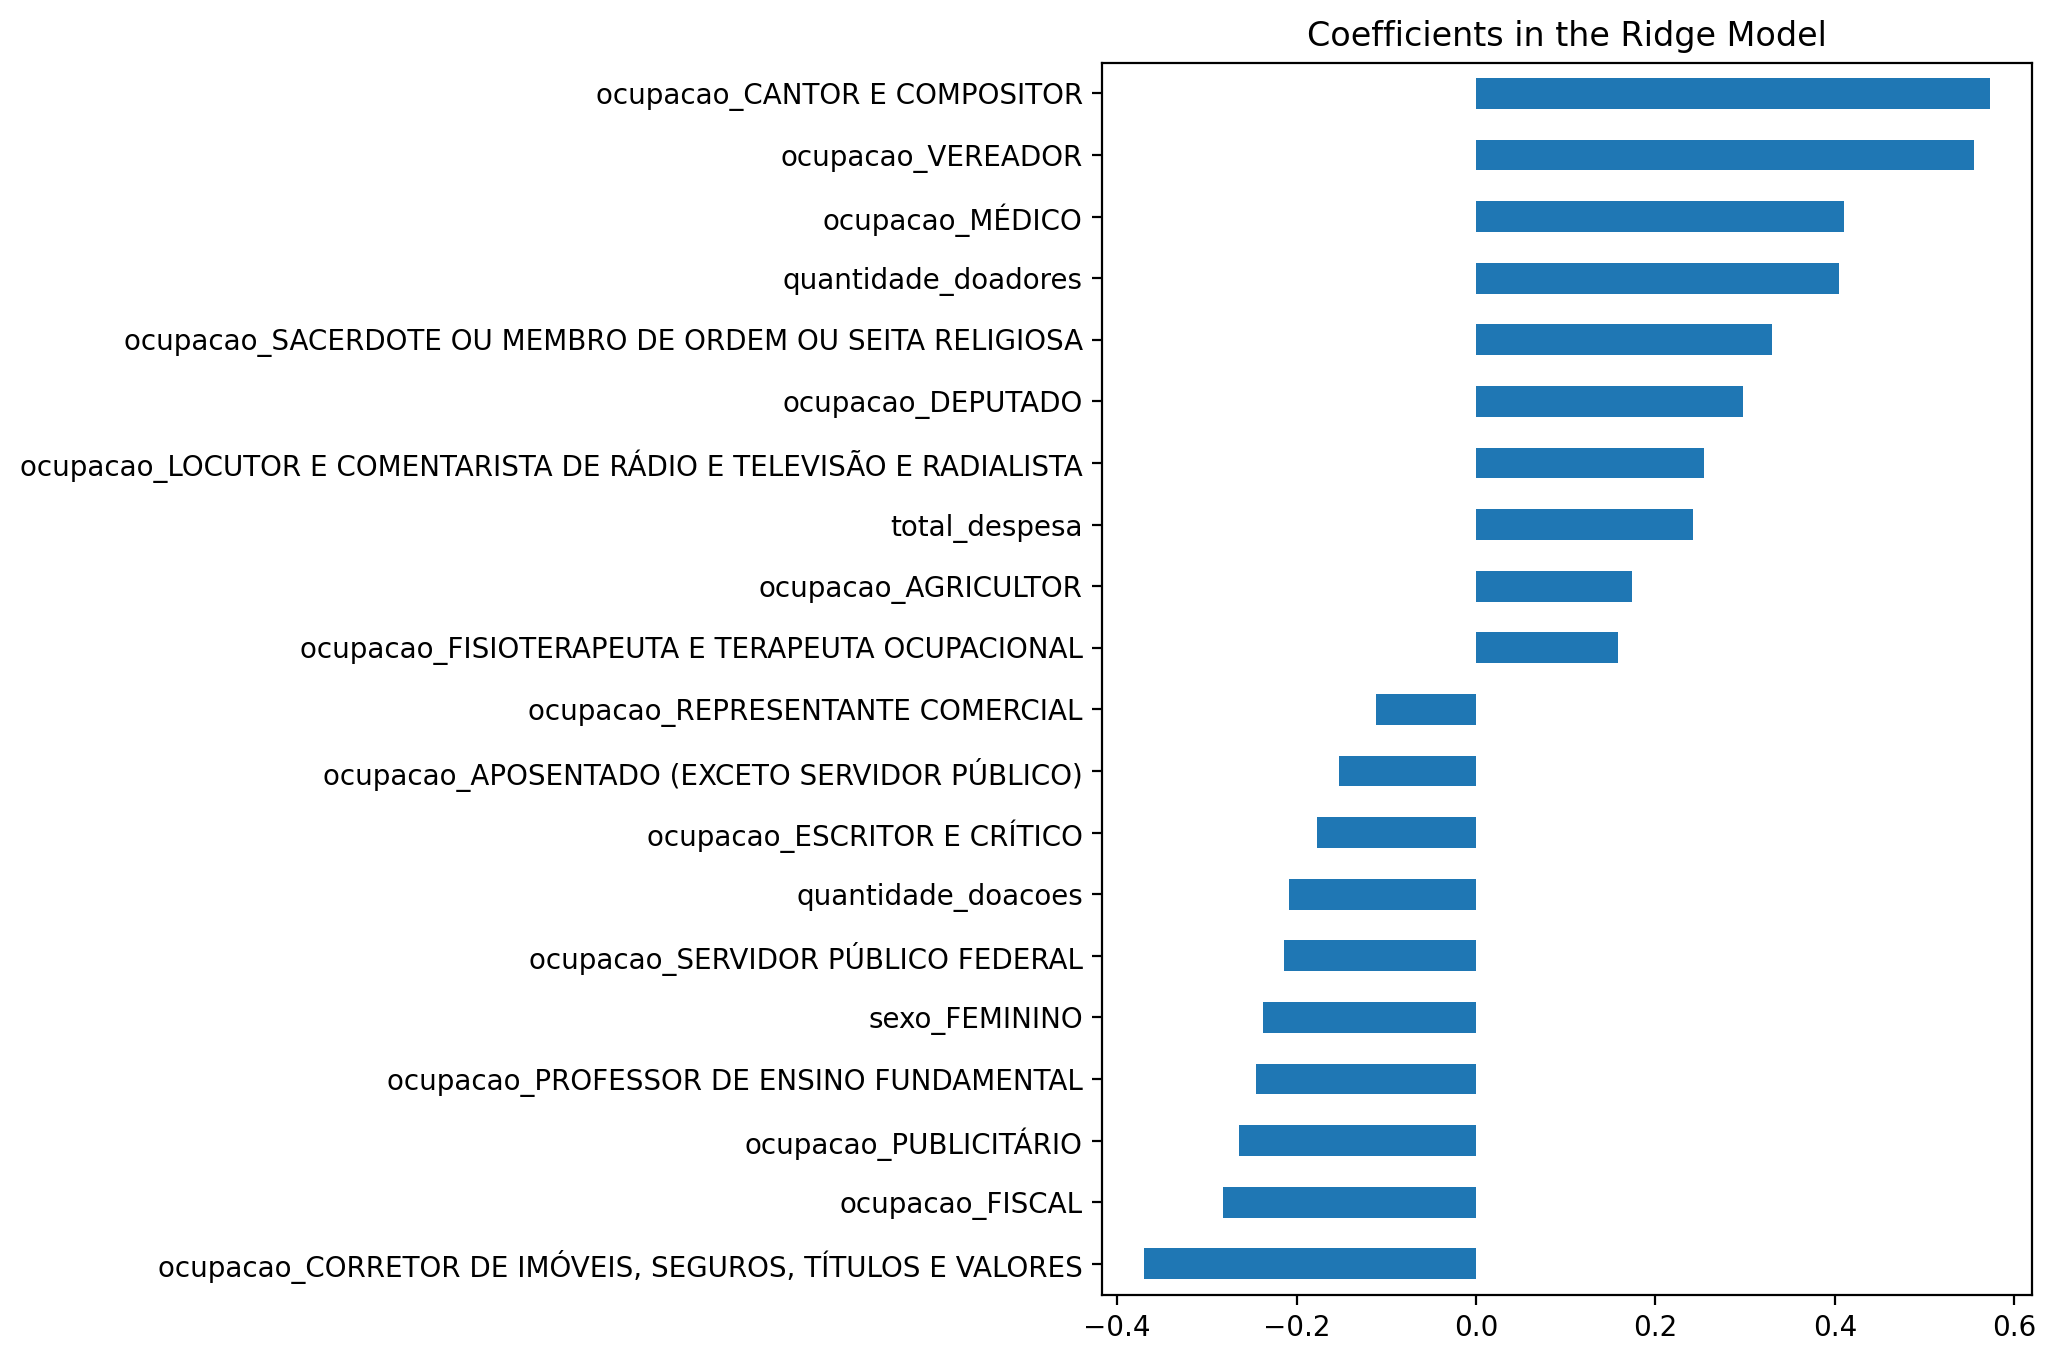

In [20]:
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

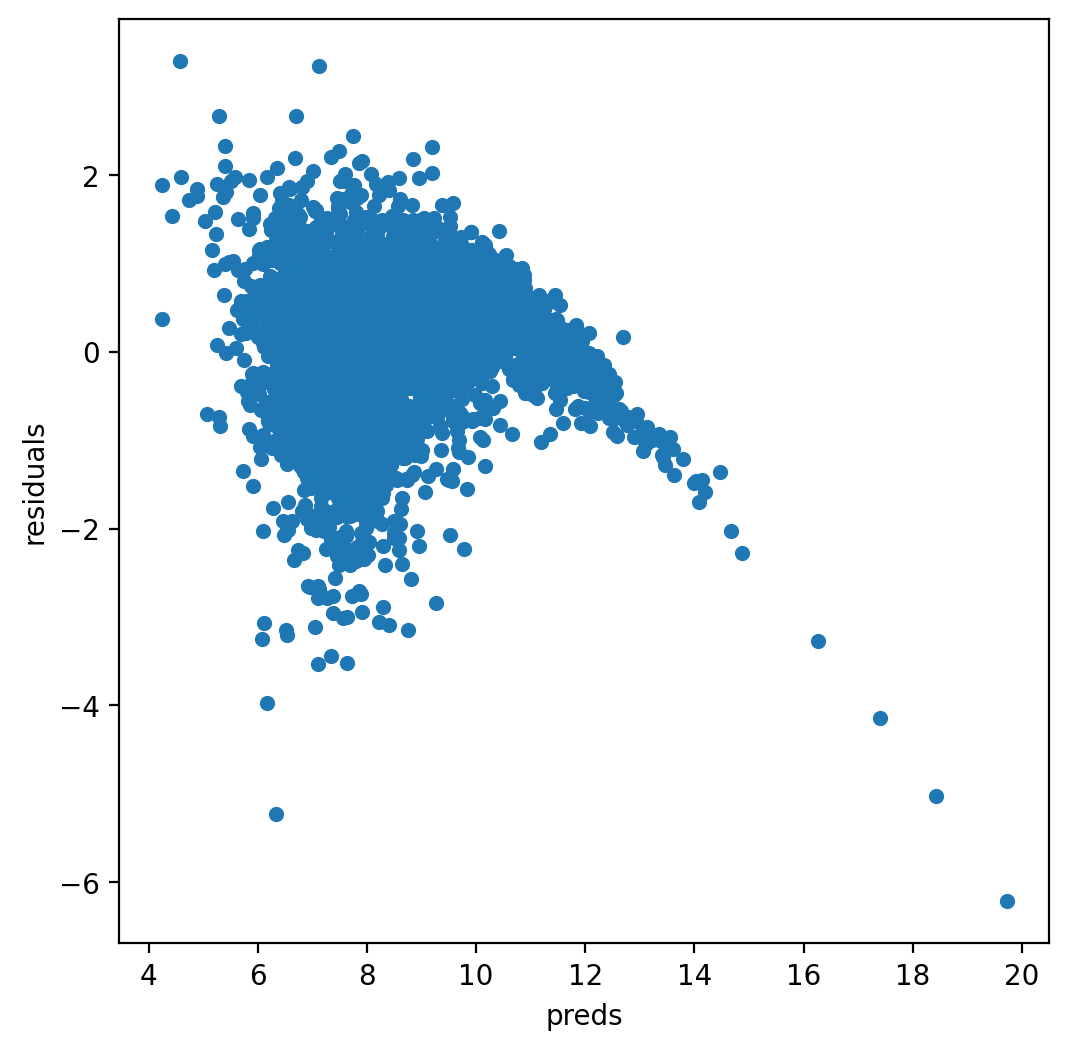

In [21]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## SVR Modelo

In [22]:
model_svr = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_svr.fit(X_train, y_train)
rmse = -cross_val_score(model_svr, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.32393462061202877

In [23]:
print("rmsr SVR Model: {}".format(rmse_cv(model_svr).mean()))

rmsr SVR Model: 0.5673584323864463


no SVR O parâmetro C é um trade off (escolha) entre a incorreta classificação de exemplos de treinamento contra a simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto visa classificar todos os exemplos de treinamento corretamente, dando ao modelo liberdade para selecionar mais amostras como vetores de suporte. O parâmetro gamma define qual é a influência de um único exemplo de treinamento. É um coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'. Se gamma for definido como 'auto' então 1/n_features serão usados. Valores baixos significam 'alta variância' e maior influência do vetor de suporte e valores altos significam 'baixa variância' e os vetores de suporte não possuem grande influência no processo de classificação. Os parâmetros gama podem ser vistos como o inverso do raio de influência de amostras selecionadas pelo modelo como vetores de suporte.

In [24]:
def testar_kernels(kernels):
    for kernel in kernels:
        classifier = svm.SVR(kernel=kernel, degree=3, 
                             gamma='scale', coef0=0.0, 
                             tol=0.001, C=1.0, epsilon=0.1, 
                             shrinking=True, cache_size=200, 
                             verbose=False, max_iter=-1)
        cv_svr = rmse_cv(classifier).mean()
        cv_svr
        #cv_svr = pd.Series(cv_svr, index = alphas)
        #print("rmse SVR: {}".format(cv_svr.min()))
#['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# o tempo de processamento do kernel linear é alto em relação aos demais
kernels = ['poly', 'rbf', 'sigmoid']
testar_kernels(kernels)

In [25]:
rmse_cv(model_svr).mean()

0.5673584323864463

<AxesSubplot:xlabel='preds', ylabel='residuals'>

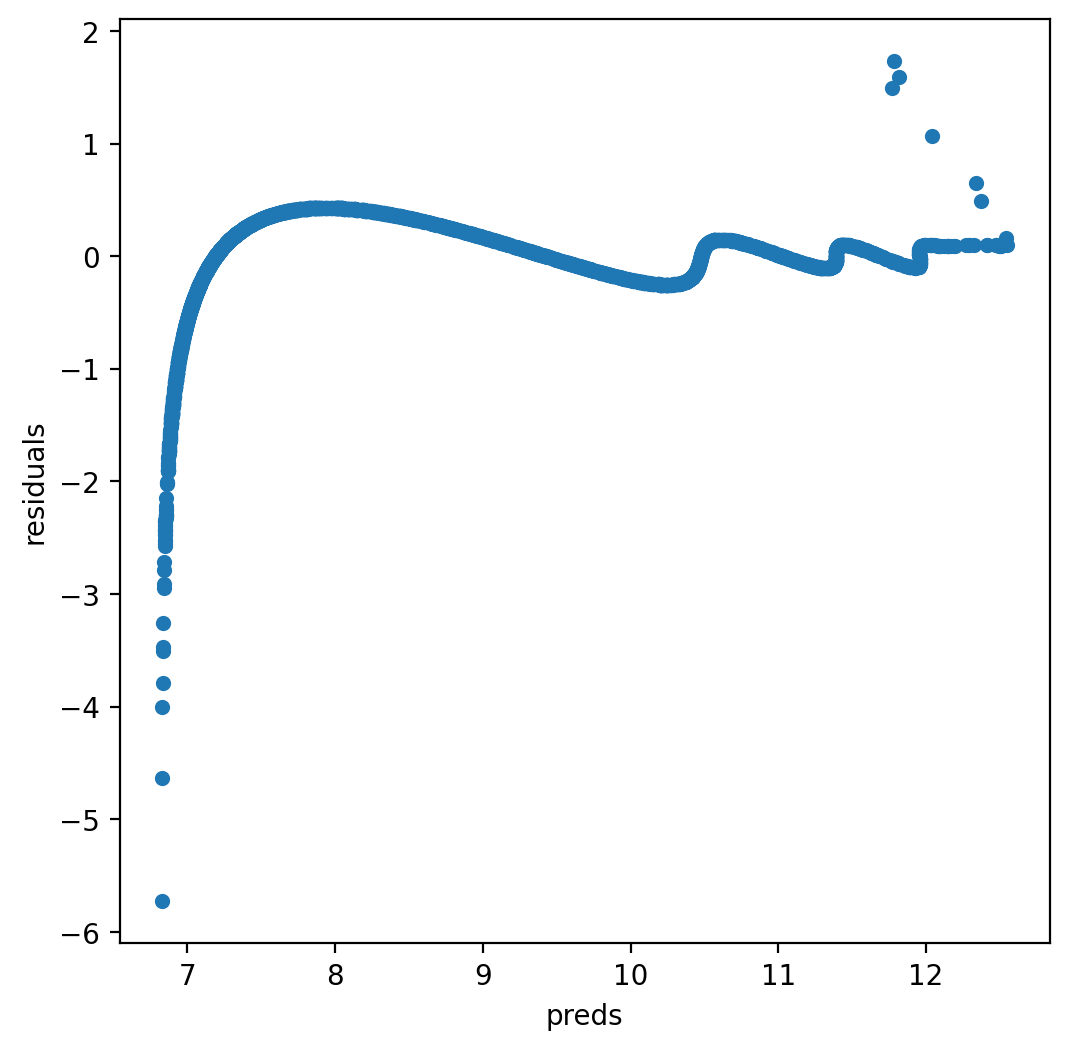

In [26]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_svr.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## RandomForestRegressor Model

In [27]:

model_random = RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)

model_random.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=43)

In [28]:
rmse = -cross_val_score(model_random, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.0013271751134926225

In [29]:
print("rmse Random: {}".format(rmse_cv(model_random).mean()))

rmse Random: 0.029694842573633244


<AxesSubplot:xlabel='preds', ylabel='residuals'>

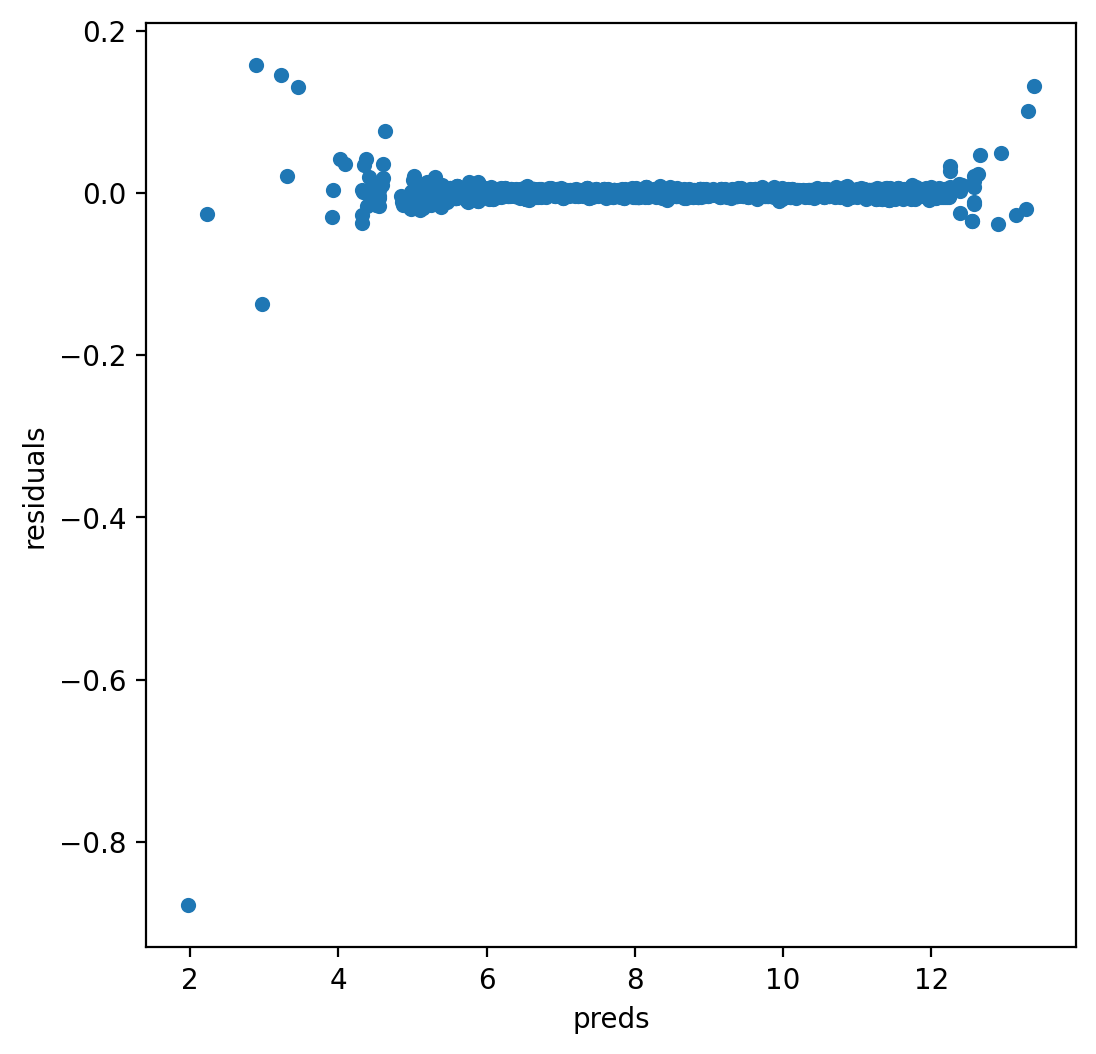

In [30]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_random.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## Analise dos Resultados

Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta

Entre o RandomForest (rmse=0.02) SVR (rmse=0.32), o Ridge(0.91) e o Lasso(0.32), o melhor modelo foi o RandomForest pois ele tinha um RMSE menor.

## XGBOOST

In [31]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

NameError: name 'y' is not defined

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
predictions = predictions[(np.abs(stats.zscore(predictions)) < 3).all(axis=1)]
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"nome":test.index, "votos":preds})
solution.to_csv("saida.csv", index = False)

## KNN Model (em construção)

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Dados de Treino
train_knn = pd.read_csv("data/eleicoes_2006_TREINO_CONFIGURADO_LIBRE.csv", index_col="nome")
del train_knn['sequencial_candidato']
del train_knn['cargo']
del train_knn['ano']
train_knn = pd.get_dummies(train_knn)
train_knn = train_knn.fillna(train_knn.mean())
X_knn = train_knn.loc[:,'quantidade_doacoes':'media_despesa']
y_knn = train_knn.loc[:,'votos']
# Dados de Teste
test_knn = pd.read_csv("data/eleicoes_2010_TESTE_CONFIGURADO_LIBRE.csv", index_col="nome")
del test_knn['sequencial_candidato']
del test_knn['cargo']
del test_knn['ano']
test_knn = pd.get_dummies(test_knn)
test_knn = test_knn.fillna(test_knn.mean())
X_test_knn = test_knn.loc[:,'quantidade_doacoes':'media_despesa']
y_test_knn = test_knn.loc[:,'votos']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_knn, y_knn)

y_pred_knn = model_knn.predict(X_test_knn)

In [ ]:
print("Accuracy on test set (Knn): {:.3f}".format(model_knn.score(X_test_knn, y_test_knn)))

In [ ]:
rmse = mean_squared_error(y_test_knn, y_pred_knn, squared=False)
rmse